# Vecchia 3D parameter estimation using maximum likelihood estimation

This example will cover:
 - Using the Vecchia approximation for drawing prior samples, inferring parameters and making predictions
 - Use maximum likelihood estimation to optimise kernel parameters

Code is heavily borrowed from github.com/mingdeyu/DGP

***GPVecchia uses `numba` so it is slow to run the first time.***

## Need to implement random search function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from gpvecchia.vecchia import GPtideVecchia
from gptide import mle, mcmc
from gpvecchia.cov import matern32
from gptide.stats import truncnorm, uniform
from gpvecchia.vecchia_utils import select_random_indices

### Generate some 3D data

In [2]:
# Create some data coordinates
np.random.seed(0)

# Number of data points
totp = 5000

# spatial coords
xs = ys = zs = 50
X = np.column_stack((np.random.uniform(0, xs, totp),
                     np.random.uniform(0, ys, totp),
                     np.random.uniform(0, zs, totp))).astype(np.float64)
Xix = np.argsort(X[:,0])
X = X[Xix] # Data would generally come sorted along one dimension - Vecchia will do some re-ordering

print(X.shape)
print(xs*ys*zs)

(5000, 3)
125000


In [3]:
# Example mean func
def my_mean(x, mean):
    return (np.ones(x.shape[0]) * mean)[:,None]

from numba import njit

@njit(cache=True)
def euclidean_vecch(X, Xpr):
    X_scaled = X - Xpr
    return np.sqrt(np.sum(X_scaled**2))

@njit(cache=True)
def matern32_covfunc_numba(x1, x2, cov_params):
    r = euclidean_vecch(x1, x2)
    return cov_params[0]**2 * matern32(r, 1.0)

In [4]:
# These are our kernel input parameters
gp_noise = 0.01
gp_std = 0.1
xl = 5
yl = 3
zl = 2
xr = -0.1
yr = 1.0
tr = 0.5

# GPVecchia parameters
n_neighbours = 30 # number of neighbours to use
cov_func = matern32_covfunc_numba
cov_params = (gp_std, xl, yl, zl, xr, yr, tr)
mean_func = my_mean
mean_params = 20.0
order_func = np.random.permutation # including a re-ordering function is important
order_params = len(X)
nn_kwargs = {'method':'sklearn'} # this SKLearn KD Tree method was fastest in testing so it is the default, but FAISS might be better on HPC

In [5]:
nn_random = select_random_indices(X, 10, [5, 3, 2], [50, 30, 20])
print(f'Randomly selected indices: {nn_random}')

Randomly selected indices: [[2976 3503 1360 ... 3242 1682 1110]
 [2815 1951 1610 ... 4728 1123 3832]
 [ 903 4125 4527 ... 1400 4373 4512]
 ...
 [3234  194 1722 ... 2474  768  554]
 [1621 2072 1807 ...  763 2954  192]
 [2272  422 3299 ...  567 1193 1474]]


### Object initialisation

In [6]:
tstart = time.time()

gp_vec = GPtideVecchia(X, 
                       X,
                       gp_noise, 
                       cov_func, 
                       cov_params,
                       mean_func=mean_func, mean_params=mean_params,
                       order_func=order_func, order_params=order_params,
                       nnum=2*n_neighbours, nn_kwargs=nn_kwargs, nn_append=nn_random,
                       scale_coords=True, rotate_coords=True, verbose=True)

init_time = time.time() - tstart
print(f'Initialisation time: {init_time:.2f} seconds for {totp} points')
print(gp_vec)
print(gp_vec.nn_array.shape)
print(gp_vec.nn_array)

Appending additional nearest neighbours to the nn_array
Initialisation time: 0.68 seconds for 5000 points
(5000, 71)
[[   0   -1   -1 ... 3242 1682 1110]
 [   1    0   -1 ... 4728 1123 3832]
 [   2    1    0 ... 1400 4373 4512]
 ...
 [4997 4991 4873 ... 2474  768  554]
 [4998 4903 4780 ...  763 2954  192]
 [4999 4963 4902 ...  567 1193 1474]]


In [7]:
gp_vec.rotate_params

array([-0.1,  1. ,  0.5])

### Draw from the prior

In [8]:
n_samp = 1

tstart = time.time()
smp_prior = gp_vec.sample_prior(samples=n_samp, add_noise=True)
sp_time = time.time() - tstart

print(f'Prior sampled in {sp_time:.2f} seconds')
print(smp_prior.shape)

Prior sampled in 8.72 seconds
(5000,)


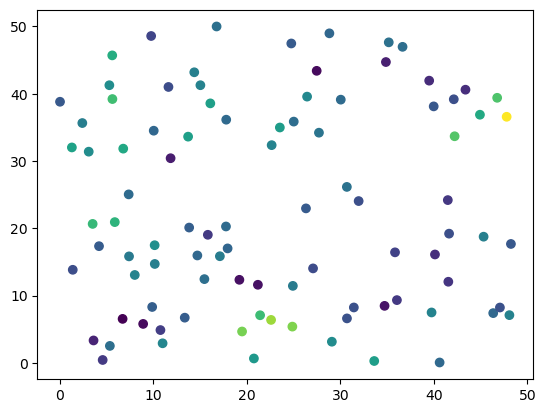

In [9]:
idx = X[:,-1] < 1
plt.scatter(X[:,0][idx], X[:,1][idx], c=smp_prior[idx], cmap='viridis')

### Evaluate the log-likelihood
Just using the true parameters here.

In [10]:
# Make one of the prior samples the input observations
y = smp_prior

sm_std = np.std(y - np.mean(y))
print(f'Small scale std dev.: {sm_std:.4}')
print(f'Mean: {np.mean(y):.4}')

tstart = time.time()
loglike = gp_vec.log_marg_likelihood(y)
ll_time = time.time() - tstart
print(f'Log likelihood computed in {ll_time:.3f} seconds')
print(loglike)

Small scale std dev.: 0.09867
Mean: 20.0
Log likelihood computed in 10.399 seconds
11575.826582475784


## Add in some random distnant points to the neighbours

## MLE 

Try to infer the hyperparameters using maximum likelihood estimation. 

Will set the tolerance high because log-likelihood is a large number.

Didn't have much luck with gradient based methods, but there is an analytical form for the log-likelihood gradient which Ming has implemented (we could add).

In [18]:
# Initial guess of the noise and covariance parameters (these can matter)
noise_ic = 0.005
covparams_ic = [0.05, 2., 1., 1., 0.0, 0.0, 0.]
meanparams_ic = [18.]

bnds_rc = [(0, None), (1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None)]
bnds_rt = [(-np.pi/8, np.pi/8), (0, np.pi), (0, np.pi)]
bnds_mn = [(None, None)]
bnds = bnds_rc + bnds_rt + bnds_mn

soln = mle(
    X,
    y,
    cov_func,
    covparams_ic,
    noise_ic,
    meanfunc=mean_func,
    meanparams_ic=meanparams_ic,
    method='Nelder-Mead',
    GPclass=GPtideVecchia,
    gp_kwargs={'order_func':order_func, 'order_params':order_params, 'nnum':n_neighbours,\
                'nn_kwargs':nn_kwargs, 'scale_coords':True, 'rotate_coords':True, 'nn_append':nn_random},
    tol=1e-1,
    bounds=bnds,
    verbose=False)


print('Noise (true): {:3.4f}, |Noise| (mle): {:3.4f}'.format(gp_noise, soln['x'][0]))
print('η (true): {:3.3f}, η (mle): {:3.3f}'.format(sm_std, soln['x'][1]))
print('ℓx (true): {:3.2f}, ℓx (mle): {:3.2f}'.format(cov_params[1], soln['x'][2]))
print('ℓy (true): {:3.2f}, ℓy (mle): {:3.2f}'.format(cov_params[2], soln['x'][3]))
print('ℓt (true): {:3.2f}, ℓt (mle): {:3.2f}'.format(cov_params[3], soln['x'][4]))
print('mean (true): {:3.2f}, mean (mle): {:3.2f}'.format(np.mean(y), soln['x'][-1]))
print('alpha (true): {:3.2f}, alpha (mle): {:3.2f}'.format(cov_params[4], soln['x'][5]))
print('beta (true): {:3.2f}, beta (mle): {:3.2f}'.format(cov_params[5], soln['x'][6]))
print('gamma (true): {:3.2f}, gamma (mle): {:3.2f}'.format(cov_params[6], soln['x'][7]))


Noise (true): 0.0100, |Noise| (mle): 0.0007
η (true): 0.099, η (mle): 0.091
ℓx (true): 5.00, ℓx (mle): 1.38
ℓy (true): 3.00, ℓy (mle): 0.87
ℓt (true): 2.00, ℓt (mle): 0.76
mean (true): 20.00, mean (mle): 20.00
alpha (true): -0.10, alpha (mle): -0.00
beta (true): 1.00, beta (mle): 0.00
gamma (true): 0.50, gamma (mle): 0.00


# MCMC

In [14]:
noise_prior      = truncnorm(0.0, 0.05, 1e-15, 1e2)  # noise
covparams_priors = [truncnorm(0, 0.2, 1e-15, 1e2),   # η
                    truncnorm(3, 3, 1e-15, 1e2),     # ℓx
                    truncnorm(3, 3, 1e-15, 1e2),     # ℓy
                    truncnorm(3, 3, 1e-15, 1e2),     # ℓt
                    uniform(-np.pi/8, np.pi/8),
                    uniform(0.0, np.pi),
                    uniform(0.0, np.pi)]
mean_prior = truncnorm(18, 4, 1e-15, 1e2)  # mean
all_priors = covparams_priors + [mean_prior]

samples, log_prob, priors_out, sampler = mcmc.emcee(X, 
                                                    y, 
                                                    cov_func, 
                                                    all_priors,
                                                    noise_prior,
                                                    GPclass=GPtideVecchia,
                                                    gp_kwargs={'order_func':order_func, 'order_params':order_params, 'nnum':2*n_neighbours,\
                                                                'nn_kwargs':nn_kwargs, 'scale_coords':True, 'rotate_coords':True, 'nn_append':nn_random},
                                                    nwarmup=100,
                                                    niter=50,
                                                    nwalkers=10*9,
                                                    verbose=False)

Running burn-in...


100%|██████████| 100/100 [1:59:27<00:00, 71.68s/it]


Running production...


100%|██████████| 50/50 [1:20:31<00:00, 96.64s/it] 


In [15]:
i = np.argmax(log_prob)
MAP = samples[i, :]

print('Noise (true): {:3.2f}, Noise (mcmc): {:3.2f}'.format(gp_noise, MAP[0]))
print('η (true): {:3.2f}, η (mcmc): {:3.2f}'.format(sm_std,  MAP[1]))
print('ℓx (true): {:3.2f}, ℓx (mcmc): {:3.2f}'.format(cov_params[1],  MAP[2]))
print('ℓy (true): {:3.2f}, ℓy (mcmc): {:3.2f}'.format(cov_params[2],  MAP[3]))
print('ℓt (true): {:3.2f}, ℓt (mcmc): {:3.2f}'.format(cov_params[3],  MAP[4]))
print('alpha (true): {:3.2f}, alpha (mcmc): {:3.2f}'.format(cov_params[4], MAP[5]))
print('beta (true): {:3.2f}, beta (mcmc): {:3.2f}'.format(cov_params[5], MAP[6]))
print('gamma (true): {:3.2f}, gamma (mcmc): {:3.2f}'.format(cov_params[6], MAP[7]))
print('mean (true): {:3.2f}, mean (mcmc): {:3.2f}'.format(np.mean(y), MAP[8]))
print(f'Max log prob: {log_prob[i][0]:.2f}')

Noise (true): 0.01, Noise (mcmc): 0.03
η (true): 0.10, η (mcmc): 1.73
ℓx (true): 5.00, ℓx (mcmc): 16.44
ℓy (true): 3.00, ℓy (mcmc): 18.83
ℓt (true): 2.00, ℓt (mcmc): 10.21
alpha (true): -0.10, alpha (mcmc): -0.14
beta (true): 1.00, beta (mcmc): 0.15
gamma (true): 0.50, gamma (mcmc): 1.49
mean (true): 20.00, mean (mcmc): 7.19
Max log prob: 9447.85


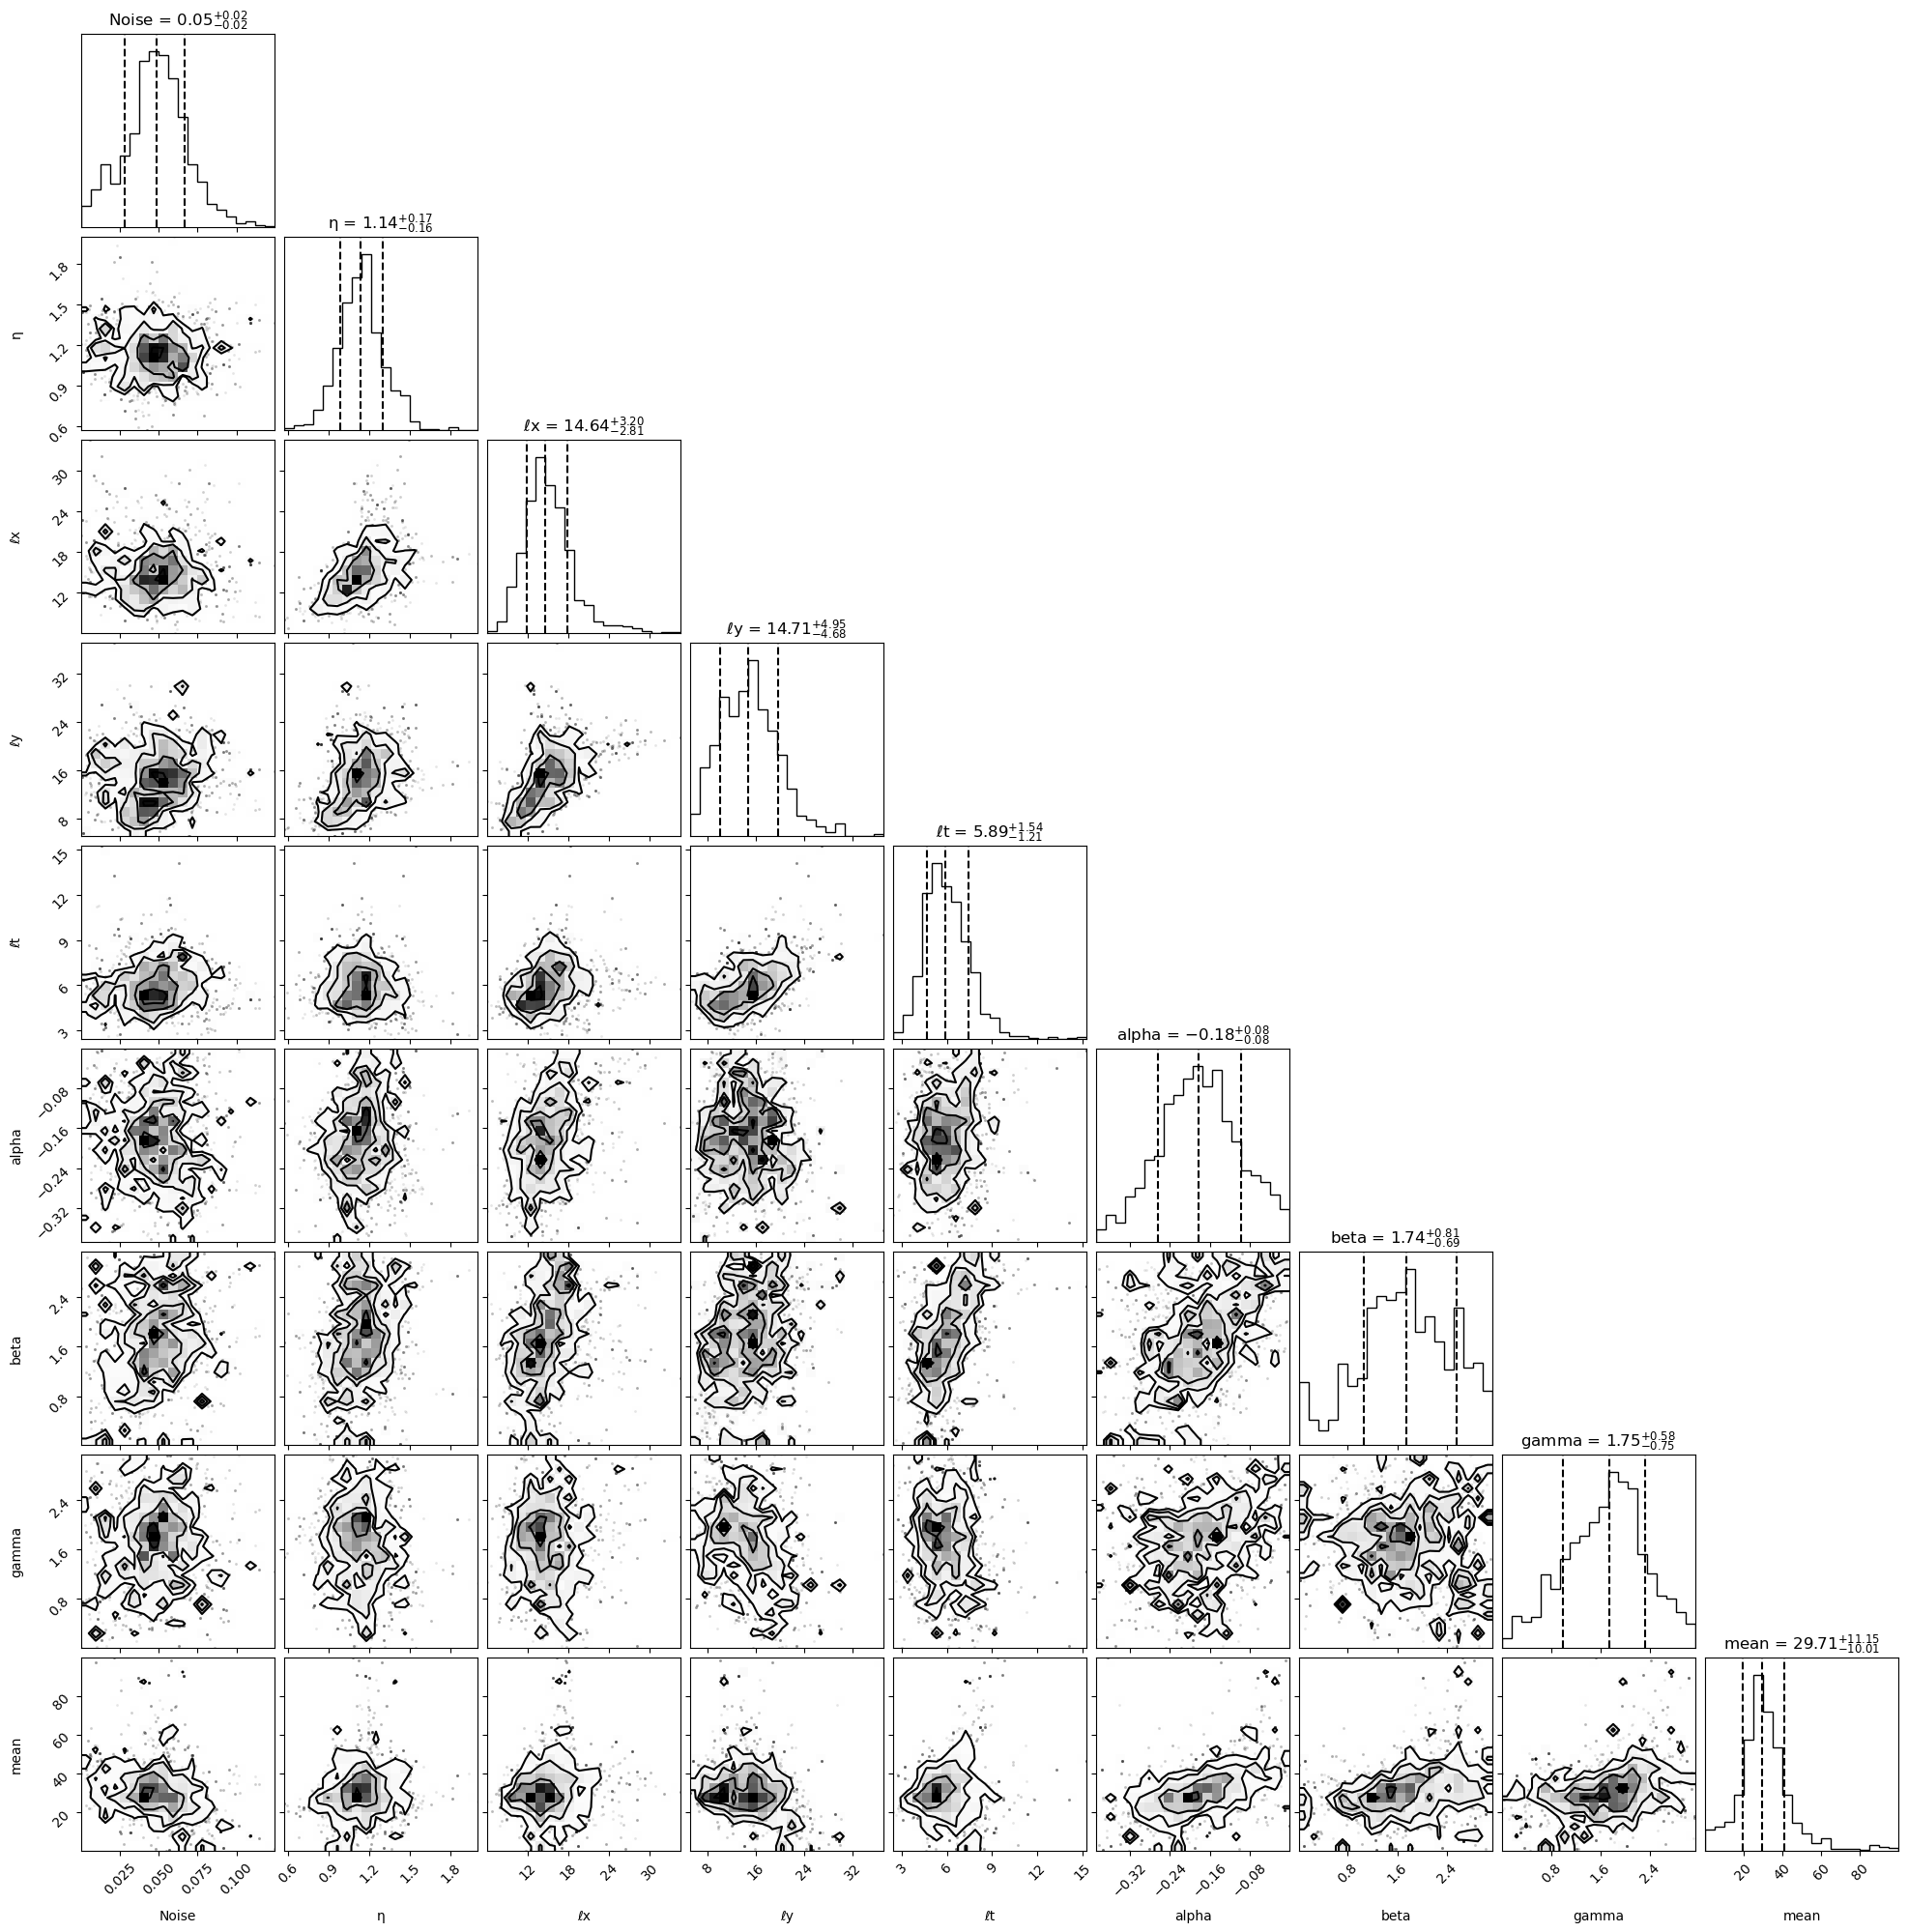

In [13]:
import corner
labels = ['Noise', 'η', 'ℓx', 'ℓy', 'ℓt', 'alpha', 'beta', 'gamma', 'mean']
fig = corner.corner(samples, 
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

### Evaluating the likelihood gradient

***Not implemented yet***

## Conditioning on data

Mean and variance predictions 

In [14]:
x_pred = np.linspace(0, xs, 50)
y_pred = np.linspace(0, ys, 50)
z_pred = np.linspace(0, zs, 20)

# Prediction points dont need to be randomly ordered
xx_grid, yy_grid, zz_grid = np.meshgrid(x_pred, y_pred, z_pred, indexing='ij')
X_pred = np.column_stack((xx_grid.ravel(), yy_grid.ravel(), zz_grid.ravel())).astype(np.float64)
print(X_pred.shape)

(50000, 3)


In [15]:
gp_vec = GPtideVecchia(X, 
                       X_pred,
                       gp_noise, 
                       cov_func, 
                       cov_params,
                       mean_func=mean_func, mean_params=mean_params,
                       order_func=order_func, order_params=order_params,
                       nnum=n_neighbours, nn_kwargs=nn_kwargs)

tstart = time.time()
y_mean, y_uq = gp_vec(y)
cnd_time = time.time() - tstart

print(f'Conditioning completed in {cnd_time:.2f} seconds')
print(y_mean.shape)
print('Pred variance:', np.var(y_mean - np.mean(y_mean)))
print(y_uq.shape)

MemoryError: Unable to allocate 18.6 GiB for an array with shape (50000, 50000) and data type float64

In [ ]:
plt.pcolormesh(xx_grid[:,:,0], yy_grid[:,:,0], y_mean.reshape(xx_grid.shape)[:,:,0], cmap='viridis')

idx = X[:,-1] == 0
plt.scatter(X[:,0][idx], X[:,1][idx], c=y[idx], cmap='viridis', ec='k', s=40)

NameError: name 'y_mean' is not defined

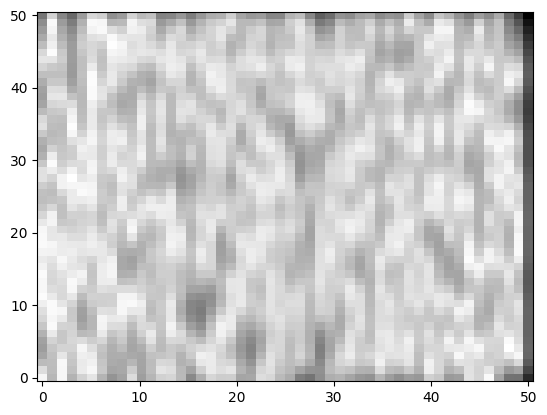

In [ ]:
plt.pcolormesh(xx_grid[:,:,0], yy_grid[:,:,0], y_uq.reshape(xx_grid.shape)[:,:,0], cmap='gray_r')

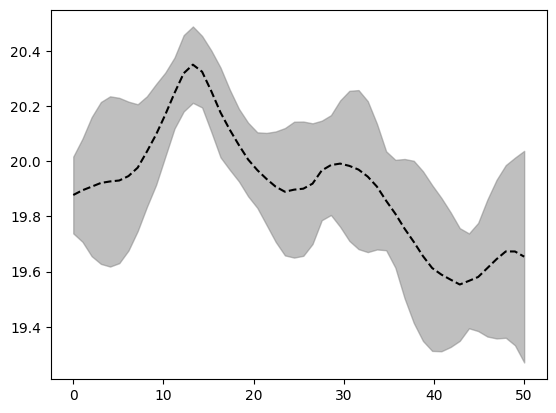

In [ ]:
plt.plot(xx_grid[:,0,0], y_mean.reshape(xx_grid.shape)[0,:,0], 'k--')
plt.fill_between(xx_grid[:,0,0],
                 y_mean.reshape(xx_grid.shape)[0,:,0] - 2*y_uq.reshape(xx_grid.shape)[0,:,0],\
                 y_mean.reshape(xx_grid.shape)[0,:,0] + 2*y_uq.reshape(xx_grid.shape)[0,:,0],\
                 color='gray', alpha=0.5)